## Install TensorFlow-GPU 2.0 and TensorRT Runtime

In [1]:
# Check tensorflow version

import tensorflow as tf
import tensorrt as trt
print('Tensorflow version: ', tf.version.VERSION)
print('TensorRT version: ', trt.__version__)

2025-01-10 20:42:39.787503: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-10 20:42:39.801089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736512959.811043    1153 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736512959.814225    1153 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 20:42:39.825223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Tensorflow version:  2.18.0
TensorRT version:  10.6.0


### Importing required libraries

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os 
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras

from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])  # 限制显存使用 6144MB
    except RuntimeError as e:
        print(e)


## Task 3: Load the Data and Pre-trained Model

### Data
We download several random images for testing from the Internet.

In [3]:
# !mkdir ./data
# !wget  -qO ./data/img0.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/Golden_Retriever_Carlos_%2810581910556%29.jpg/640px-Golden_Retriever_Carlos_%2810581910556%29.jpg"
# !wget  -qO ./data/img1.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/6/62/Red-shouldered_Hawk_%28Buteo_lineatus%29_-_Blue_Cypress_Lake%2C_Florida.jpg/407px-Red-shouldered_Hawk_%28Buteo_lineatus%29_-_Blue_Cypress_Lake%2C_Florida.jpg"
# !wget  -qO ./data/img2.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Ostrich_male_RWD.jpg/636px-Ostrich_male_RWD.jpg"
# !wget  -qO ./data/img3.JPG "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Working_pay_phone%2C_Jensen_Beach%2C_Florida%2C_September_4%2C_2012_001.JPG/360px-Working_pay_phone%2C_Jensen_Beach%2C_Florida%2C_September_4%2C_2012_001.JPG"

### Model

Thoughout this project, we will be using InceptionV3. Here we import the model from Keras.

In [4]:
model = keras.applications.InceptionV3(weights='imagenet')

I0000 00:00:1736512963.654771    1153 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6144 MB memory:  -> device: 0, name: NVIDIA RTX 3500 Ada Generation Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


I0000 00:00:1736512966.990625    1325 service.cc:148] XLA service 0x7f588006a530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736512966.991785    1325 service.cc:156]   StreamExecutor device (0): NVIDIA RTX 3500 Ada Generation Laptop GPU, Compute Capability 8.9
2025-01-10 20:42:47.054540: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736512967.556068    1325 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-01-10 20:42:59.486388: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng54{k2=5,k12=-1,k13=1,k14=2,k15=0,k17=48,k18=1,k23=0} for conv (f32[1,96,17,17]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,96,35,35]{3,2,1,0}, f32[96,96,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config"

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
./data/img0.JPG - Predicted: [('n02099601', 'golden_retriever', np.float32(0.7230669)), ('n02099712', 'Labrador_retriever', np.float32(0.11998279)), ('n02104029', 'kuvasz', np.float32(0.021433316))]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
./data/img1.JPG - Predicted: [('n01608432', 'kite', np.float32(0.9784904)), ('n01807496', 'partridge', np.float32(0.0015487947)), ('n01798484', 'prairie_chicken', np.float32(0.0007000395))]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


I0000 00:00:1736512971.976364    1325 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


./data/img2.JPG - Predicted: [('n01518878', 'ostrich', np.float32(0.89907664)), ('n02018795', 'bustard', np.float32(0.0029248288)), ('n02437616', 'llama', np.float32(0.0010660605))]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
./data/img3.JPG - Predicted: [('n03902125', 'pay-phone', np.float32(0.98869425)), ('n03187595', 'dial_telephone', np.float32(0.0082352385)), ('n02977058', 'cash_machine', np.float32(4.3782587e-05))]


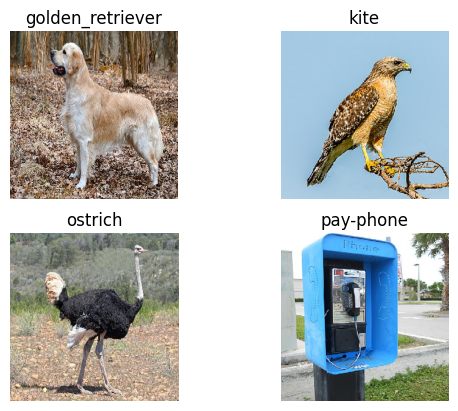

In [5]:
def show_predictions(model):
    for i in range(4):
        img_path = './data/img{image}.JPG'.format(image=i)
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)

        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        preds = model.predict(x)
        pred_decoded = decode_predictions(preds, top=3)
        print('{} - Predicted: {}'.format(img_path, pred_decoded[0]))

        plt.subplot(2, 2, i+1)
        plt.imshow(img);
        plt.axis('off');
        plt.title(pred_decoded[0][0][1])

show_predictions(model)

When we benchmark our optimized TF-TRT models, they will be saved TensorFlow (not Keras) models. In order to have a fair comparison, here we save our Keras model as a TensorFlow modelm

In [6]:
model.export('./inceptionv3_saved_model')

INFO:tensorflow:Assets written to: ./inceptionv3_saved_model/assets


INFO:tensorflow:Assets written to: ./inceptionv3_saved_model/assets


Saved artifact at './inceptionv3_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1000), dtype=tf.float32, name=None)
Captures:
  140023709659232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140023709847568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140023709848272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140023709846336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140023709853904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140023709853376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140023709852672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140023709851616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140023709857600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140023709974592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14

## Task 4: Create Batched Input

Using **batch inference** to send many images to the GPU at once promotes parallel processing and improve throughput.

The `batch_input` helper function takes a batch_size, and returns a tensor with the preprocessed images.

In [7]:
# Rerun after kernel restart

def batch_input_prepare(batch_size=8):
    batch_input = np.zeros((batch_size, 299, 299, 3), dtype=np.float32)
    for i in range(batch_size):
        img_path = './data/img%d.JPG' % (i%4)
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        batch_input[i, :] = x

    # convert np to tensorflow tensor
    batch_input = tf.constant(batch_input)
    return batch_input        

In [8]:
# Re-run after Kernel restart

batch = batch_input_prepare(batch_size=32)

In [9]:
type(batch)

tensorflow.python.framework.ops.EagerTensor

In [10]:
batch.shape

TensorShape([32, 299, 299, 3])

## Task 5: Load TensorFlow SavedModel

In [11]:
# Re-run after kernel restart

def load_tf_saved_model(input_saved_dir):
    print(f'Loading saved model{input_saved_dir}...')
    # load model
    saved_model = tf.saved_model.load(input_saved_dir, tags=[tag_constants.SERVING])
    return saved_model

Here we load a previously saved InceptionV3 model.

In [12]:
saved_model = load_tf_saved_model('./inceptionv3_saved_model')

Loading saved model./inceptionv3_saved_model...


这两句代码的作用是从已加载的 TensorFlow `SavedModel` 中获取模型的推理（inference）函数，并打印出该推理函数的输出结构。

我们来详细解析一下：

### 1. **`saved_model.signatures['serving_default']`**
在 TensorFlow 中，`SavedModel` 格式是一个保存了模型结构、权重、优化器状态等信息的目录。当你保存模型为 `SavedModel` 格式时，TensorFlow 会默认创建一个称为 `serving_default` 的 "signature"。

- **Signatures** 是 TensorFlow `SavedModel` 格式中的一种机制，用于定义输入和输出的函数接口。每个 signature 都是一个字典，它将名称映射到一个 TensorFlow 操作（通常是推理操作）的 `ConcreteFunction`。
  
- `saved_model.signatures` 返回的是一个字典，包含了模型中的所有签名（不同的输入输出接口）。其中，`'serving_default'` 是最常见的默认签名，表示模型的主要推理入口，通常用于推理或预测。

#### 示例：
```python
# 加载已保存的模型
import tensorflow as tf
saved_model = tf.saved_model.load('path_to_saved_model')

# 获取默认推理函数
infer = saved_model.signatures['serving_default']
```

在这里，`infer` 就是 `serving_default` 签名对应的推理函数，它是一个 `ConcreteFunction`，表示模型的实际执行操作。

### 2. **`print(infer.structured_outputs)`**
`infer` 是一个 `ConcreteFunction`，它代表了模型的推理操作。`structured_outputs` 是 `ConcreteFunction` 的一个属性，它返回模型输出的结构。

- `structured_outputs` 以结构化的形式表示模型的输出。对于模型的每个输出，`structured_outputs` 会显示其类型和形状。例如，如果模型有多个输出（比如分类概率和某些中间层的输出），这个属性会展示每个输出的 TensorFlow 数据类型（如 `tf.float32`）和形状（如 `(batch_size, num_classes)`）。

#### 例子：
假设你有一个分类模型，`serving_default` 推理签名返回一个形状为 `(None, 1000)` 的输出，表示预测每个类的概率。在这种情况下，`structured_outputs` 会显示类似以下内容：

```python
# 输出的结构化信息
{
  'output_1': <tf.Tensor: shape=(None, 1000), dtype=float32>
}
```

### 总结：
1. **`saved_model.signatures['serving_default']`** 获取模型的默认推理函数（`ConcreteFunction`）。
2. **`infer.structured_outputs`** 打印模型推理函数的输出结构，显示输出的类型和形状。

这两行代码通常用于检查加载的模型的输出形式，特别是在进行推理时，以便理解模型返回的数据结构。

In [13]:
infer = saved_model.signatures['serving_default']
print(infer.structured_outputs)

{'output_0': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='output_0')}


## Task 6: Get Baseline for Prediction Throughput and Accuracy

### Naive Inference with TensorFlow 2

The following will serve as a baseline for prediction throughput and accuracy. Now we perform inference with the optimized graph, and after a warmup, time and calculate throughput.

The helper function `predict_and_benchmark_throughput` will use the passed in model to perform predictions on the passed in batched input over a number of runs. It measures and reports throughput, as well as time for ranges of runs.

Due to GPU initialization operations, we do not want to profile against initial inference -- so we can set a number of warmup runs to perform prior to benchmarking.

`predict_and_benchmark_throughput` returns the predictions for all images for all runs, after the warmup.

In [14]:
# Re-run after kernel restart
def predict_and_benchmark_throughput(batched_input, infer, N_warmup_run=50, N_run=1000):
    elapsed_time = []
    all_preds = []
    batch_size = batched_input.shape[0]

    # warm up 
    for i in range(N_warmup_run):
        labeling = infer(batched_input)
        preds = labeling['output_0'].numpy()
    
    # benchmark
    for i in range(N_run):
        start_time = time.perf_counter()
        labeling = infer(batched_input)
        preds = labeling['output_0'].numpy()
        end_time = time.perf_counter()
        elapsed_time = np.append(elapsed_time, end_time - start_time)
        all_preds.append(preds)

        if i!=0 and i%50 == 0:
            print('Steps - {} - {} average: {:4.1f} ms'.format(i, i+50, (elapsed_time[-50:].mean()) * 1000))
    print('Throughput: {:.0f} images/s'.format(N_run* batch_size/elapsed_time.sum()))
    return all_preds
    

In [15]:
all_preds = predict_and_benchmark_throughput(batch, infer, N_warmup_run=50, N_run=1000)

Steps - 50 - 100 average: 54.6 ms
Steps - 100 - 150 average: 54.8 ms
Steps - 150 - 200 average: 54.7 ms
Steps - 200 - 250 average: 55.1 ms
Steps - 250 - 300 average: 57.3 ms
Steps - 300 - 350 average: 54.6 ms
Steps - 350 - 400 average: 55.2 ms
Steps - 400 - 450 average: 55.6 ms
Steps - 450 - 500 average: 54.3 ms
Steps - 500 - 550 average: 54.2 ms
Steps - 550 - 600 average: 54.6 ms
Steps - 600 - 650 average: 54.7 ms
Steps - 650 - 700 average: 54.6 ms
Steps - 700 - 750 average: 56.5 ms
Steps - 750 - 800 average: 56.3 ms
Steps - 800 - 850 average: 55.1 ms
Steps - 850 - 900 average: 56.1 ms
Steps - 900 - 950 average: 55.1 ms
Steps - 950 - 1000 average: 55.0 ms
Throughput: 580 images/s


### Observe Accuracy

**NOTE:** We are not so concerned in this project about the accuracy of our predictions per se, only that they remain consistent as we optimize our models.

In [16]:
# Re-run after kernel restart
def show_predictions(model):
    img_path = './data/img1.JPG'
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    x = tf.constant(x)

    labeling = model(x)

    preds = labeling['output_0'].numpy()

    preds_decoded = decode_predictions(preds, top=3)
    print('{} - Predicted: {}'.format(img_path, preds_decoded[0]))
    plt.subplot(2, 2, 1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(preds_decoded[0][0][1])
    

./data/img1.JPG - Predicted: [('n01608432', 'kite', np.float32(0.9784949)), ('n01807496', 'partridge', np.float32(0.0015563085)), ('n01798484', 'prairie_chicken', np.float32(0.0007013554))]


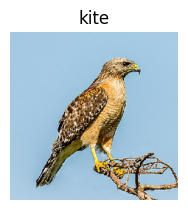

In [17]:
show_predictions(infer)

Before going to the next Task, please execute the cell below to restart the kernel and clear GPU memory.

In [18]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Graph Conversion

To perform graph conversion, we use `TrtGraphConverterV2`, passing it the directory of a saved model, and any updates we wish to make to its conversion parameters.

```python
from tensorflow.python.compiler.tensorrt import trt_convert as trt

trt.TrtGraphConverterV2(
    input_saved_model_dir=None,
    conversion_params=TrtConversionParams(precision_mode='FP32',
                                          max_batch_size=1
                                          minimum_segment_size=3,
                                          max_workspace_size_bytes=8000000000,
                                          use_calibration=True,
                                          maximum_cached_engines=1,
                                          is_dynamic_op=True,
                                          rewriter_config_template=None,
                                         )
```

### Conversion Parameters

Here is additional information about the most frequently adjusted conversion parameters.

* __precision_mode__: This parameter sets the precision mode; which can be one of FP32, FP16, or INT8. Precision lower than FP32, meaning FP16 and INT8, would improve the performance of inference. The FP16 mode uses Tensor Cores or half precision hardware instructions, if possible. The INT8 precision mode uses integer hardware instructions.

* __max_batch_size__: This parameter is the maximum batch size for which TF-TRT will optimize. At runtime, a smaller batch size may be chosen, but, not a larger one.

* __minimum_segment_size__: This parameter determines the minimum number of TensorFlow nodes in a TF-TRT engine, which means the TensorFlow subgraphs that have fewer nodes than this number will not be converted to TensorRT. Therefore, in general, smaller numbers such as 5 are preferred. This can also be used to change the minimum number of nodes in the optimized INT8 engines to change the final optimized graph to fine tune result accuracy.

* __max_workspace_size_bytes__: TF-TRT operators often require temporary workspace. This parameter limits the maximum size that any layer in the network can use. If insufficient scratch is provided, it is possible that TF-TRT may not be able to find an implementation for a given layer.

# Task 7: Convert a TensorFlow saved model into a TF-TRT Float32 Graph

Convert a TensorFlow saved model into a TF-TRT optimized graph using Float32 precision. We will use the optimized graph to make predictions and will benchmark its performance.

Only a few lines of code are needed to use TF-TRT
```python
from tensorflow.python.compiler.tensorrt import trt_convert as trt

conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
  precision_mode=trt.TrtPrecisionMode.<FP16 or FP32>
  max_workspace_bytes=8000000000
)

converter = trt.TrtGraphConverterV2(
  input_saved_model_dir=input_saved_model_dir,
  conversion_params=conversion_params
)

converter.convert()

converter.save(output_saved_model_dir)
```

In [19]:
# Re-run after Kernel restart
from tensorflow.python.compiler.tensorrt import trt_convert as trt

## Task 8: Benchmark TF-TRT Float32

Load the optimized TF model.

In [20]:
def convert_to_trt_graph_and_save(precision_mode='float32', input_saved_model_dir='inceptionv3_saved_model', calibaration_data=batch):
    if precision_mode == 'float32':
        precision_mode = trt.TrtPrecisionMode.FP32
        converted_save_suffix = '__TFRT_FP32'

    # Float16 precision mode
    if precision_mode == 'float16':
        precision_mode = trt.TrtPrecisionMode.FP16
        converted_save_suffix = '__TFRT_FP16'

    # Int8 precision mode
    if precision_mode == 'int8':
        precision_mode = trt.TrtPrecisionMode.INT8
        converted_save_suffix = '__TFRT_INT8'

    output_saved_model_dir = input_saved_model_dir + converted_save_suffix

    # necessary conversion parameters
    conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=precision_mode, max_workspace_size_bytes=8000000000)

    # convert to tf graph
    converter = trt.TrtGraphConverterV2(input_saved_model_dir=input_saved_model_dir, conversion_params=conversion_params)

    print(f'Converting {input_saved_model_dir} to TF_RT graph precision mode {precision_mode}...')

    # calibaration
    if precision_mode == trt.TrtPrecisionMode.INT8:
        def input_calibrate():
            yield (calibaration_data)
        converter.convert(input_calibrate=input_calibrate)
    else:
        converter.convert()

    print(f'Saving converted model to {output_saved_model_dir}')
    converter.save(output_saved_model_dir=output_saved_model_dir)
    print('Finished!')


In [21]:
convert_to_trt_graph_and_save(precision_mode='float32', input_saved_model_dir='inceptionv3_saved_model')

ERROR:tensorflow:Tensorflow needs to be built with TensorRT support enabled to allow TF-TRT to operate.


ERROR:tensorflow:Tensorflow needs to be built with TensorRT support enabled to allow TF-TRT to operate.


RuntimeError: Tensorflow has not been built with TensorRT support.